# Synthetic CDO Tranches Pricing

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm, sem
import matplotlib.pyplot as plt

### Load Data

In [2]:
data = pd.read_csv('HYCDXIndex.csv')
data = data.dropna()
data = data.reset_index(drop=True)

display(data)

,CDX HY CDSI GEN 5Y SPRD Corp,INDX_MEMBERS,Ticker,CDS Spread,parent ticker exchange
0,American Airlines Group Inc,Senior,CAMR1U5,226.62930,AAL US
1,American Axle & Manufacturing,Senior,CT370292,400.23600,AXL US
2,Amkor Technology Inc,Senior,CT356410,139.44510,AMKR US
3,Antero Resources Corp,Senior,CY459512,131.09430,AR US
4,Anywhere Real Estate Group LLC,Senior,CX404670,224.86780,1354039D US
...,...,...,...,...,...
87,Univision Communications Inc,Senior,CX376096,724.38150,TLEVICPO MM
88,Vistra Operations Co LLC,Senior,CY498153,137.33470,1457130D US
89,Weatherford International Ltd,Senior,CWFT1U5,125.99680,1052513D SW
90,Xerox Corp,Senior,CXRX1U5,313.26470,XRX US


### Assign Issuer Tickers and Sectors

In [3]:
# Split parent ticker and exchange
data[['parent ticker', 'parent exchange']] = data['parent ticker exchange'].str.split(' ', expand=True)

# Fix ticker symbols
ticker_fix_map = {
    'GPS': 'GAP',           # Gap Inc. (NYSE: GPS) changed its ticker symbol to GAP on August 22, 2024
    'CHK': 'CPK',           # Chesapeake Energy Corporation (CHK) changed its name and trading symbol to Expand Energy Corporation (EXE) on October 2, 2024
    'ETRN': 'EQT',          # On July 22, 2024, Equitrans Midstream was acquired by EQT Corporation. 
    'TLEVICPO': '0583654D', # Univision Communications Inc. was acquired by a private equity firm, completed on December 29, 2020
    'RADCQ': '',            # Rite Aid's common stock was delisted from NYSE on October 16, 2023
    'CVC': 'ATUS',          # CSC Holdings LLC, a subsidiary of Altice USA (NYSE: ATUS), does not have its own US stock symbol
    'BBD/B': 'BBD-B.TO'     # The Bombardier Inc. Class B Subordinate Voting Shares on the Toronto Stock Exchange (TSX)
}

data['parent ticker'] = data['parent ticker'].replace(ticker_fix_map)

# Flag public and private tickers
data['is_public'] = data['parent ticker'].str.match(r'^[A-Z\.-]+$')

public_tickers = data[data['is_public']]['parent ticker'].to_list()
private_tickers = data[~data['is_public']]['parent ticker'].to_list()

# 'QRTEA' price data is not available
public_tickers.remove('QRTEA')
private_tickers.append('QRTEA')

In [4]:
# Fetch sector information for public tickers
public_sector_map = {}
for symbol in public_tickers:
    try:
        info = yf.Ticker(symbol).info
        sector = info.get('sector')
        if sector:
            public_sector_map[symbol] = sector
    except Exception as e:
        print(f"Error fetching sector for {symbol}: {e}")

data['sector'] = data['parent ticker'].map(public_sector_map)

unique_sectors = sorted(set(public_sector_map.values()))

display(unique_sectors)

['Basic Materials',
 'Communication Services',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Energy',
 'Financial Services',
 'Healthcare',
 'Industrials',
 'Real Estate',
 'Technology',
 'Utilities']

In [5]:
# Map private tickers to sectors
private_sector_map = {
    'QRTEA': 'Consumer Cyclical',
    '1354039D': 'Real Estate',
    '1778675D': 'Basic Materials',
    '1532897D': 'Utilities',
    '3247463Z': 'Communication Services',
    '0487125D': 'Communication Services',
    '8370997Z': 'Basic Materials',
    '1004036D': 'Communication Services',
    '1581942D': 'Consumer Defensive',
    '338249Z': 'Basic Materials',
    '8146495Z': 'Consumer Cyclical',
    '1993618D': 'Industrials',
    '': 'Consumer Defensive',
    '1541027D': 'Consumer Cyclical',
    '1308461D': 'Industrials',
    '1426382D': 'Consumer Cyclical',
    '0583654D': 'Communication Services',
    '1457130D': 'Utilities',
    '1052513D': 'Energy'
}

data['sector'] = data.apply(
    lambda row: private_sector_map.get(row['parent ticker'], row['sector']) if pd.isna(row['sector']) else row['sector'],
    axis=1
)

display(data)

,CDX HY CDSI GEN 5Y SPRD Corp,INDX_MEMBERS,Ticker,CDS Spread,parent ticker exchange,parent ticker,parent exchange,is_public,sector
0,American Airlines Group Inc,Senior,CAMR1U5,226.62930,AAL US,AAL,US,True,Industrials
1,American Axle & Manufacturing,Senior,CT370292,400.23600,AXL US,AXL,US,True,Consumer Cyclical
2,Amkor Technology Inc,Senior,CT356410,139.44510,AMKR US,AMKR,US,True,Technology
3,Antero Resources Corp,Senior,CY459512,131.09430,AR US,AR,US,True,Energy
4,Anywhere Real Estate Group LLC,Senior,CX404670,224.86780,1354039D US,1354039D,US,False,Real Estate
...,...,...,...,...,...,...,...,...,...
87,Univision Communications Inc,Senior,CX376096,724.38150,TLEVICPO MM,0583654D,MM,False,Communication Services
88,Vistra Operations Co LLC,Senior,CY498153,137.33470,1457130D US,1457130D,US,False,Utilities
89,Weatherford International Ltd,Senior,CWFT1U5,125.99680,1052513D SW,1052513D,SW,False,Energy
90,Xerox Corp,Senior,CXRX1U5,313.26470,XRX US,XRX,US,True,Technology


### Calculate Issuer-Market Correlation

In [6]:
# Fetch Public Issuers' Weekly Price Data
weekly_price = yf.download(['SPY']+public_tickers, start="2022-01-01", end="2025-01-01", interval='1wk')['Close']

# Calculate weekly returns
weekly_returns = np.log(weekly_price / weekly_price.shift(1)).dropna()

# Calculate correlation with SPY
rho = weekly_returns.corr().loc['SPY'].drop('SPY')

# Map correlation to data
data['rho'] = data['parent ticker'].map(rho)

# Fill private issuers' rho values with sector averages
sector_avg_rho = data[data['rho'].notna()].groupby('sector')['rho'].mean()

data['rho'] = data.apply(
    lambda row: sector_avg_rho[row['sector']] if pd.isna(row['rho']) else row['rho'],
    axis=1
)

[******                12%                       ]  9 of 74 completed

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  74 of 74 completed


### 1-Factor Gaussian Copula Simulation

In [7]:
# Assume CDS spread as default intensity
lambda_ = data['CDS Spread'].values/ 10000 # Convert bps to decimal

# Correlation with SPY
rho = data['rho'].values

# Time to maturity
T = 5

# Number of CDS
N = len(rho)

$$
X_i = \sqrt{\rho_i} \cdot M + \sqrt{1 - \rho_i} \cdot Z_i
$$


In [8]:
np.random.seed(42)

num_sims = 10000

M = np.random.randn(num_sims)       # Common market factor
Z = np.random.randn(num_sims, N)    # Idiosyncratic risk

X = np.sqrt(rho) * M[:, None] + np.sqrt(1 - rho) * Z

### Determine default

In [9]:
# Calculate 5-year cumulative default probabilities
p_default = 1 - np.exp(-lambda_ * T)

# Convert default probabilities into thresholds
thresholds = norm.ppf(p_default)

# Simulate defaults
defaults = (X < thresholds).astype(int)

### Compute Portfolio Loss

In [10]:
# Compute total portfolio loss per simulation
portfolio_loss = defaults.sum(axis=1) / N

### Calculate Tranche Losses

In [11]:
# Define tranche loss function
def tranche_loss(losses, attach, detach):
    return np.clip((losses - attach) / (detach - attach), 0, 1)

# Compute losses in each tranche
equity = tranche_loss(portfolio_loss, 0.00, 0.05)
mezzanine = tranche_loss(portfolio_loss, 0.05, 0.15)
senior = tranche_loss(portfolio_loss, 0.15, 0.25)
super_senior = tranche_loss(portfolio_loss, 0.25, 1.00)

### Calculate Fair Spread Values

In [12]:
# Calculate spreads
equity_spread = equity.mean() / T
mezz_spread = mezzanine.mean() / T
senior_spread = senior.mean() / T
super_spread = super_senior.mean() / T

# Standard error of the mean
equity_se = sem(equity) / T
mezz_se = sem(mezzanine) / T
senior_se = sem(senior) / T
super_se = sem(super_senior) / T

# Create a summary dictionary
summary = {
    'Tranche': ['Equity (0–5%)', 'Mezzanine (5–15%)', 'Senior (15–25%)', 'Super Senior (25–100%)'],
    'Fair Spread (%)': [
        equity_spread * 100,
        mezz_spread * 100,
        senior_spread * 100,
        super_spread * 100
    ],
    'Error Bound (± %)': [
        equity_se * 100,
        mezz_se * 100,
        senior_se * 100,
        super_se * 100
    ]
}

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary)
display(summary_df)

,Tranche,Fair Spread (%),Error Bound (± %)
0,Equity (0–5%),17.632870,0.048069
1,Mezzanine (5–15%),9.359217,0.084168
2,Senior (15–25%),4.099565,0.074456
3,Super Senior (25–100%),0.542464,0.018756


### Analyze Spread Values for each Correlation Level

In [13]:
results = []

for corr in np.linspace(0, 1, 11):
    test_rho = np.full_like(rho, corr)  # same rho for all issuers
    
    # Simulate X
    M = np.random.randn(num_sims)
    Z = np.random.randn(num_sims, N)
    X = np.sqrt(test_rho) * M[:, None] + np.sqrt(1 - test_rho) * Z

    # Simulate defaults
    p_default = 1 - np.exp(-lambda_ * T)
    thresholds = norm.ppf(p_default)
    defaults = (X < thresholds).astype(int)
    portfolio_loss = defaults.sum(axis=1) / N

    # Tranche loss
    equity = tranche_loss(portfolio_loss, 0.00, 0.05)
    mezz   = tranche_loss(portfolio_loss, 0.05, 0.15)
    senior = tranche_loss(portfolio_loss, 0.15, 0.25)
    super  = tranche_loss(portfolio_loss, 0.25, 1.00)

    # Store average spreads
    results.append({
        'correlation': corr,
        'equity': equity.mean() / T,
        'mezzanine': mezz.mean() / T,
        'senior': senior.mean() / T,
        'super_senior': super.mean() / T
    })

### Plot Correlation Sensitivity

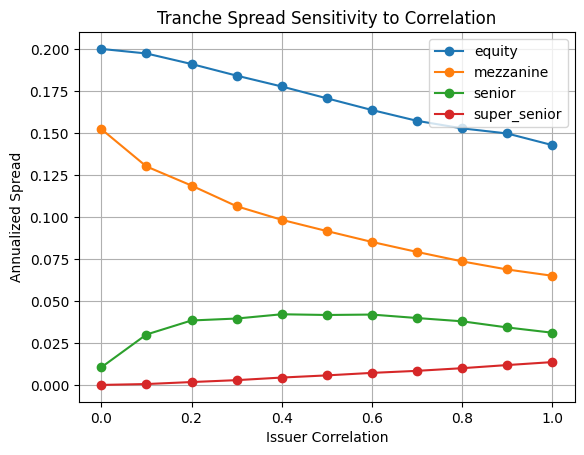

In [ ]:
df = pd.DataFrame(results)

df.set_index('correlation')[['equity', 'mezzanine', 'senior', 'super_senior']].plot(marker='o')
plt.title("Tranche Spread Sensitivity to Correlation")
plt.ylabel("Annualized Spread")
plt.xlabel("Issuer Correlation")
plt.grid(True)
# plt.savefig('correlation_sensitivity.png', dpi=300)
plt.show()